# fig4F

Begin robust gene identification
After filtration, 30647/30654 genes are kept.     Among 30647 genes, 29896 genes are robust.
End of robust gene identification.
Begin size normalization: pearson and HVGs selection pearson
Time to analyze data in cpu: 10.202256679534912 seconds.
End of size normalization: pearson and HVGs selection pearson


2026-02-02 22:22:49,040 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2026-02-02 22:22:50,059 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-02-02 22:22:50,106 - harmonypy - INFO - Iteration 1 of 10
2026-02-02 22:22:52,235 - harmonypy - INFO - Iteration 2 of 10
2026-02-02 22:22:54,349 - harmonypy - INFO - Converged after 2 iterations


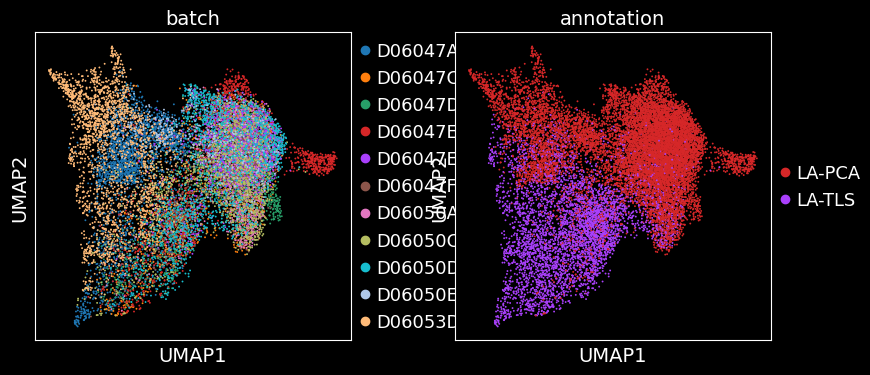

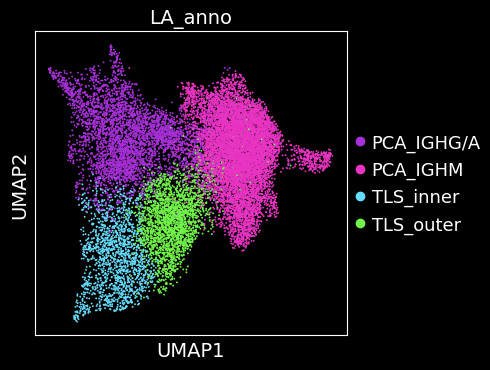

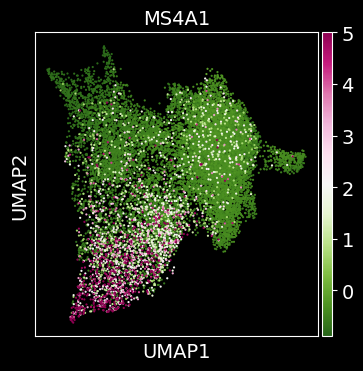

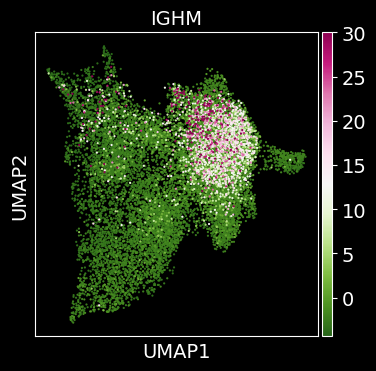

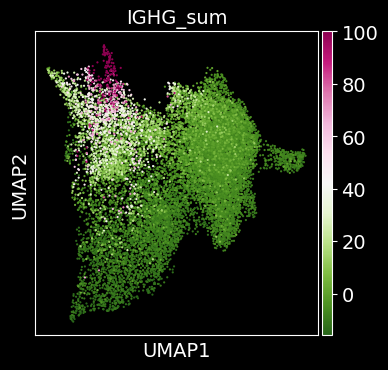

LA trajectory analysis and visualization completed.


In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import anndata as ad
import omicverse as ov

def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=600, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=600, vector_friendly=True)
vector(False)
# Set dark background for all plots
plt.style.use('dark_background')

# ===============================
# Load and Preprocess Data
# ===============================

# Load AnnData object containing LA trajectory data
LA_bin50 = sc.read_h5ad('/data1/fengyu/methods/trajectory/LA_for_trajectory.h5ad')

# Preprocess using omicverse: Pearson correlation, select top 3000 HVGs
LA_bin50 = ov.pp.preprocess(LA_bin50, mode='pearson|pearson', n_HVGs=3000)
# If needed, you could use:
# LA_bin50 = ov.pp.preprocess(LA_bin50, mode='shiftlog|pearson', n_HVGs=3000)

# Save raw data
LA_bin50.raw = LA_bin50

# Keep only highly variable genes for downstream analysis
LA_bin50 = LA_bin50[:, LA_bin50.var.highly_variable_features]

# Scale data and compute PCA
ov.pp.scale(LA_bin50)
ov.pp.pca(LA_bin50, layer='scaled', n_pcs=50)

# Optional: Non-linear dimensionality reduction (disabled/removed; see original comments)

# ===============================
# Batch Integration with Harmony
# ===============================
# Integrate batches using Harmony
sc.external.pp.harmony_integrate(LA_bin50, 'batch')
# Update principal components with Harmony output
LA_bin50.obsm['X_pca'] = LA_bin50.obsm['X_pca_harmony']

# ===============================
# Build Neighbors and UMAP
# ===============================
sc.pp.neighbors(LA_bin50, n_neighbors=10, n_pcs=40)
sc.tl.umap(LA_bin50)

# ===============================
# Plot UMAP with batch and annotation
# ===============================
sc.pl.umap(LA_bin50, color=["batch", "annotation"])

# ===============================
# Refine Neighborhood/Clustering
# ===============================
sc.pp.neighbors(LA_bin50, n_neighbors=15, n_pcs=50, use_rep='X_pca')
# Cluster using Leiden algorithm
ov.utils.cluster(LA_bin50, method='leiden', resolution=1)

# ===============================
# Manual Annotation of Clusters for LA subtypes
# ===============================
LA_bin50.obs['LA_anno'] = 'PCA_IGHM'
LA_bin50.obs.loc[LA_bin50.obs.leiden.isin(['3', '5', '6']), 'LA_anno'] = 'PCA_IGHG/A'
LA_bin50.obs.loc[LA_bin50.obs.leiden.isin(['2']), 'LA_anno'] = 'TLS_outer'
LA_bin50.obs.loc[LA_bin50.obs.leiden.isin(['4']), 'LA_anno'] = 'TLS_inner'

# ===============================
# Plotting Panel for LA Annotation
# ===============================
sc.pl.umap(
    LA_bin50,
    color=['LA_anno'],
    palette=['#A830D8', '#EA34C4', '#66DDFC', '#72F54A'],
    save='fig4F1.png'
)

# ===============================
# Expression Panel for Key Marker Genes on UMAP
# ===============================
cmap = 'PiYG_r'
sc.pl.umap(LA_bin50, color=['MS4A1'], use_raw=False, cmap=cmap, vmax=5, s=10, save='fig4F2.png')
sc.pl.umap(LA_bin50, color=['IGHM'], use_raw=False, cmap=cmap, vmax=30, s=10, save='fig4F3.png')

# ===============================
# Compute IGHG Sum (across subtypes) and Plot
# ===============================
# Calculate IGHG sum for each cell (sum over IGHG1, IGHG2, IGHG3, IGHG4)
LA_bin50.obs['IGHG_sum'] = np.sum(
    [LA_bin50[:, gene].X for gene in ['IGHG1', 'IGHG2', 'IGHG3', 'IGHG4']],
    axis=0
)
sc.pl.umap(
    LA_bin50,
    color='IGHG_sum',
    use_raw=False,
    cmap=cmap,
    vmax=100,
    s=10,
    save='fig4F4.png'
)

print("LA trajectory analysis and visualization completed.")

# fig4G&H&I

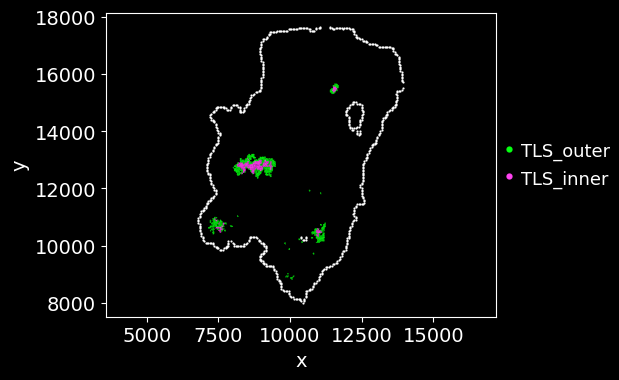

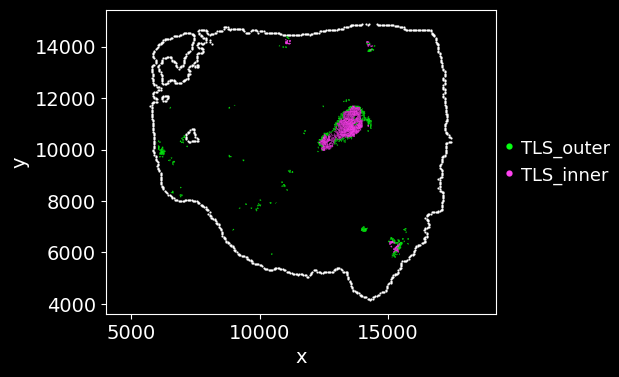

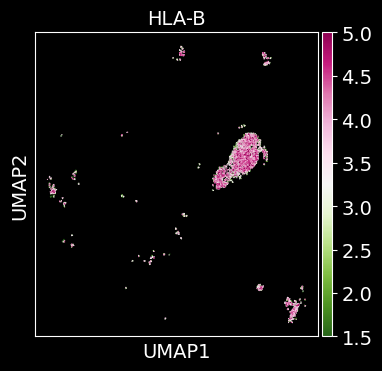

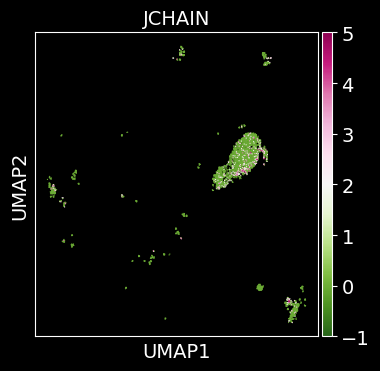

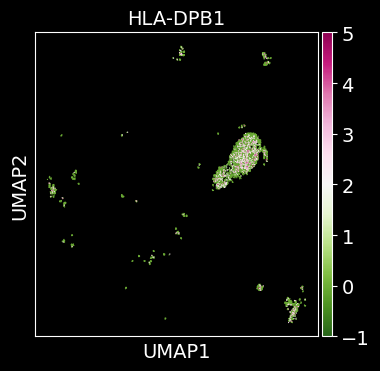

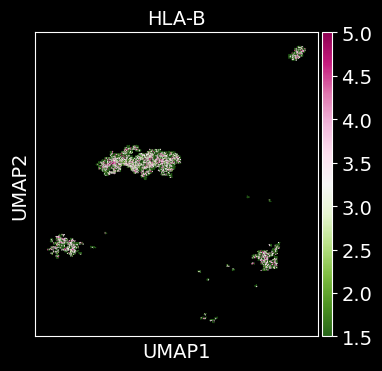

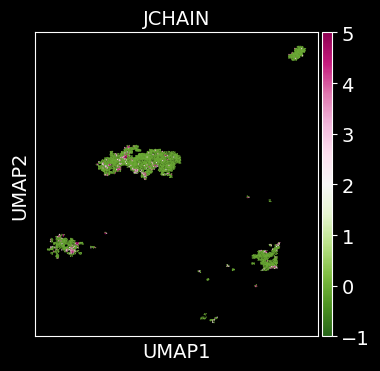

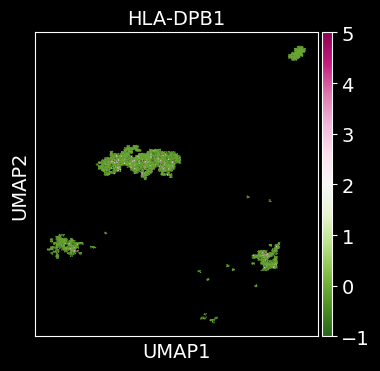

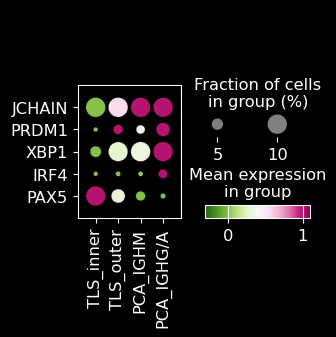

In [5]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# =======================
# Data Loading & Metadata
# =======================

# Load processed AnnData object containing all samples
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad')

# Load location annotation metadata
meta = pd.read_csv('/data1/fengyu/methods/fig5/LA_bin50_meta.csv', index_col=0)

# Construct 'loc' identifier and merge LA_anno annotation
adata.obs['loc'] = (
    adata.obs['batch'].astype(str) + '_' +
    adata.obs['bin50_x'].astype(str) + '_' +
    adata.obs['bin50_y'].astype(str)
)
adata.obs = adata.obs.merge(meta[['loc', 'LA_anno']], on='loc', how='left')

# Load specific batches for tissue outline plotting
adata4 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047E1/test_analysis_celltype/D06047E1.h5ad')
adata1 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047A2/test_analysis_celltype/D06047A2.h5ad')

# ==========================
# Plot TLS Distribution Map
# ==========================

def plot_tls_outline(adata, single_adata, batch_id, fig_path, figsize=(5, 4)):
    """
    Plots the tissue outline and highlights TLS_inner and TLS_outer regions within the tissue.
    """
    plt.style.use('dark_background')
    plt.figure(figsize=figsize)
    # Extract tissue outline coordinates from .uns
    tissue_outline = pd.DataFrame(single_adata.uns['tissue_outline'], columns=['x', 'y'])
    sns.scatterplot(data=tissue_outline, x='x', y='y', color='white', s=2)
    # Overlay annotated TLS regions
    tls_points = adata[
        (adata.obs['batch'] == batch_id) & 
        (adata.obs['LA_anno'].isin(['TLS_inner', 'TLS_outer']))
    ].obs
    sns.scatterplot(
        data=tls_points,
        x='x', y='y',
        hue='LA_anno',
        edgecolor=None,
        palette=['#05FF11', '#FF42F0'],
        s=0.2
    )
    plt.legend(
        loc="center left", 
        bbox_to_anchor=(1, 0.5), 
        markerscale=10
    )
    plt.grid(False)
    plt.axis('equal')
    plt.savefig(fig_path, dpi=2500, bbox_inches='tight')
    plt.show()

# Create outline plots for two example samples (Fig4G1, Fig4G2)
plot_tls_outline(adata, adata4, 'D06047E1', './fig4G1.png')
plot_tls_outline(adata, adata1, 'D06047A2', './fig4G2.png')

# =================================
# Expression Normalization & Filter
# =================================

# Normalize and log1p transform counts for main AnnData object
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Filter AnnData for cells with LA_anno annotation
adata.obs.index = adata.obs.index.astype(str)
LA = adata[adata.obs['LA_anno'].notna()]

# ================================
# Gene Expression Spatial Mapping
# ================================

def plot_tls_gene_spatial(adata, batch_id, gene, cmap, vmin, vmax, save_path):
    """
    Plots spatial gene expression for TLS regions in a specific batch/sample.
    """
    plt.style.use('dark_background')
    tmp = adata[adata.obs['batch'] == batch_id].copy()
    # Use spatial coordinates for dimensional reduction plot
    tmp.obsm['X_umap'] = tmp.obsm['spatial']
    # Plot for cells in TLS_inner and TLS_outer only
    sc.pl.umap(
        tmp[tmp.obs['LA_anno'].isin(['TLS_inner', 'TLS_outer'])], 
        color=[gene],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        s=3,
        use_raw=False,
        save=save_path,
    )

# Example plotting for D06047A2 (Fig4H1-H3)
plot_tls_gene_spatial(adata, 'D06047A2', 'HLA-B', 'PiYG_r', 1.5, 5, 'fig4H1.png')
plot_tls_gene_spatial(adata, 'D06047A2', 'JCHAIN', 'PiYG_r', -1, 5, 'fig4H2.png')
plot_tls_gene_spatial(adata, 'D06047A2', 'HLA-DPB1', 'PiYG_r', -1, 5, 'fig4H3.png')

# Example plotting for D06047E1 (Fig4H4-H6)
plot_tls_gene_spatial(adata, 'D06047E1', 'HLA-B', 'PiYG_r', 1.5, 5, 'fig4H4.png')
plot_tls_gene_spatial(adata, 'D06047E1', 'JCHAIN', 'PiYG_r', -1, 5, 'fig4H5.png')
plot_tls_gene_spatial(adata, 'D06047E1', 'HLA-DPB1', 'PiYG_r', -1, 5, 'fig4H6.png')

# ====================================
# Dotplot for B/Plasma Genes in Subset
# ====================================

# Dotplot for marker genes in plasma cells/b cells in selected spatial regions (Fig4I)
marker_genes = ['JCHAIN', 'PRDM1', 'XBP1', 'IRF4', 'PAX5']
dotplot_data = adata[
    (adata.obs['anno'].isin(['plasma_cell', 'b_cell'])) &
    (adata.obs['bin50 structural annotation'].isin(['LA-TLS', 'LA-PCA']))
]

sc.pl.dotplot(
    dotplot_data, 
    marker_genes, 
    dot_max=0.1, 
    cmap='PiYG_r', 
    standard_scale='var', 
    vmax=1.1, vmin=-0.3,
    groupby='LA_anno', 
    swap_axes=True, 
    use_raw=False,
    categories_order=['TLS_inner', 'TLS_outer', 'PCA_IGHM', 'PCA_IGHG/A'],
    save='fig4I.pdf'
)

# ==============
# End of script
# ==============

# fig4J&K

Begin robust gene identification
After filtration, 30815/32065 genes are kept.     Among 30815 genes, 24676 genes are robust.
End of robust gene identification.
Begin size normalization: pearson and HVGs selection pearson
Time to analyze data in cpu: 5.599626779556274 seconds.
End of size normalization: pearson and HVGs selection pearson
Lineages: [Lineage[2, 3, 0], Lineage[2, 3, 1]]


  0%|          | 0/1 [00:00<?, ?it/s]

Reversing from leaf to root
Averaging branch @3 with lineages: [0, 1] [<pcurvepy2.pcurve.PrincipalCurve object at 0x72ca53de7640>, <pcurvepy2.pcurve.PrincipalCurve object at 0x72ca53de4070>]
Shrinking branch @3 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x72ca53de7640>, <pcurvepy2.pcurve.PrincipalCurve object at 0x72ca53de4070>]


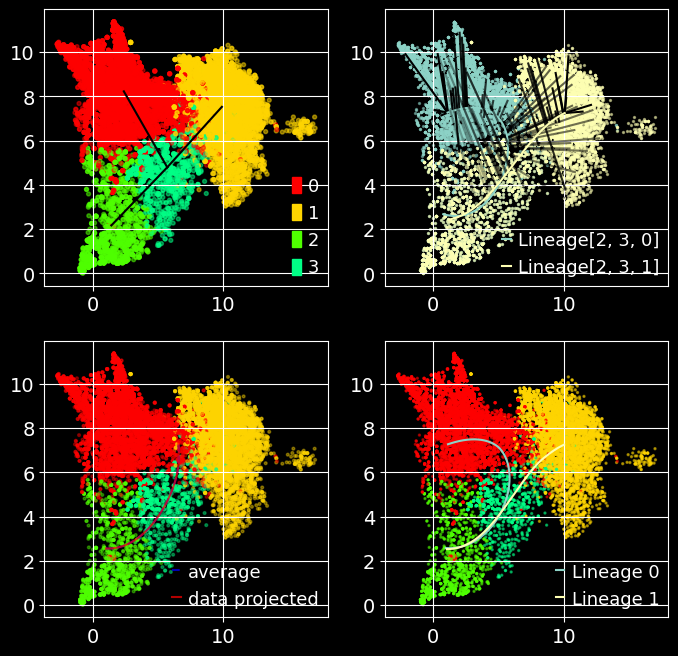

In [7]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import omicverse as ov

# ===========================
# Data Loading and Preprocess
# ===========================

# Load main AnnData object
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad')

# Construct 'loc' identifier for matching spots/cells
adata.obs['loc'] = (
    adata.obs['batch'].astype(str) + '_' +
    adata.obs['bin50_x'].astype(str) + '_' +
    adata.obs['bin50_y'].astype(str)
)

# Load UMAP embedding and annotation for selected locations
LA_bin50 = sc.read_h5ad('/data1/fengyu/methods/zy/Review/for_github/fig4--ok/LA_bin50.h5ad')
LA_bin50.obs[['umap_X', 'umap_Y']] = LA_bin50.obsm['X_umap']

# ===================================
# Select Cells for TLS Trajectory Plot
# ===================================

# Subset cells that have both location annotation and either heavy or light chain CDR3 sequence
LA_cells = adata[adata.obs['loc'].isin(LA_bin50.obs['loc'])]
LA_cells = LA_cells[
    (LA_cells.obs['IGHcdr3aa'].notna()) | (LA_cells.obs['IGK/Lcdr3aa'].notna())
]

# Merge necessary annotation/UMAP coordinates
LA_cells.obs = LA_cells.obs.merge(
    LA_bin50.obs[['loc', 'LA_anno', 'umap_X', 'umap_Y']],
    on='loc'
)

# Assign UMAP coordinates to .obsm for plotting/trajectory input
umap_coords = np.column_stack([
    LA_cells.obs['umap_X'].values,
    LA_cells.obs['umap_Y'].values
])
LA_cells.obsm['X_umap'] = umap_coords

# ======================================
# Highly Variable Gene Selection, Scaling
# ======================================

# Preprocess using OpenVerse to select HVGs and normalize
LA_cells = ov.pp.preprocess(LA_cells, mode='pearson|pearson', n_HVGs=3000)

# Save raw counts
LA_cells.raw = LA_cells

# Filter for highly variable features
LA_cells = LA_cells[:, LA_cells.var['highly_variable_features']]

# Scale and PCA
ov.pp.scale(LA_cells)
ov.pp.pca(LA_cells, layer='scaled', n_pcs=50)

# ========================
# Trajectory Inference
# ========================

Traj = ov.single.TrajInfer(
    LA_cells,
    basis='X_umap',
    groupby='LA_anno',
    use_rep='scaled|original|X_pca',
    n_comps=50
)

# Set origin cells to TLS_inner (trajectory starting population)
Traj.set_origin_cells('TLS_inner')

# Plotting: creates a 2x2 grid of trajectory inference diagnostics/plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
Traj.inference(method='slingshot', num_epochs=1, debug_axes=axes)

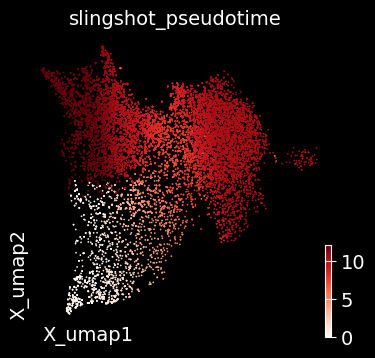

In [8]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import omicverse as ov
adata1 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047A2/test_analysis_celltype/D06047A2.h5ad')
#adata2 = sc.read_h5ad('/data1/fengyu/methods/zy/D06047A2/combine_3_meta/Final_D06047A2_after_processed_withThree_meta.h5ad')
LA_cells = sc.read_h5ad('/data1/fengyu/methods/zy/Review/for_github/fig4--ok/LA_cells.h5ad')
ov.pl.embedding(
    LA_cells,
    basis='X_umap',
    color=['slingshot_pseudotime'],
    frameon='small',
    cmap='Reds',
    save='fig4J.png'
)

# fig4I

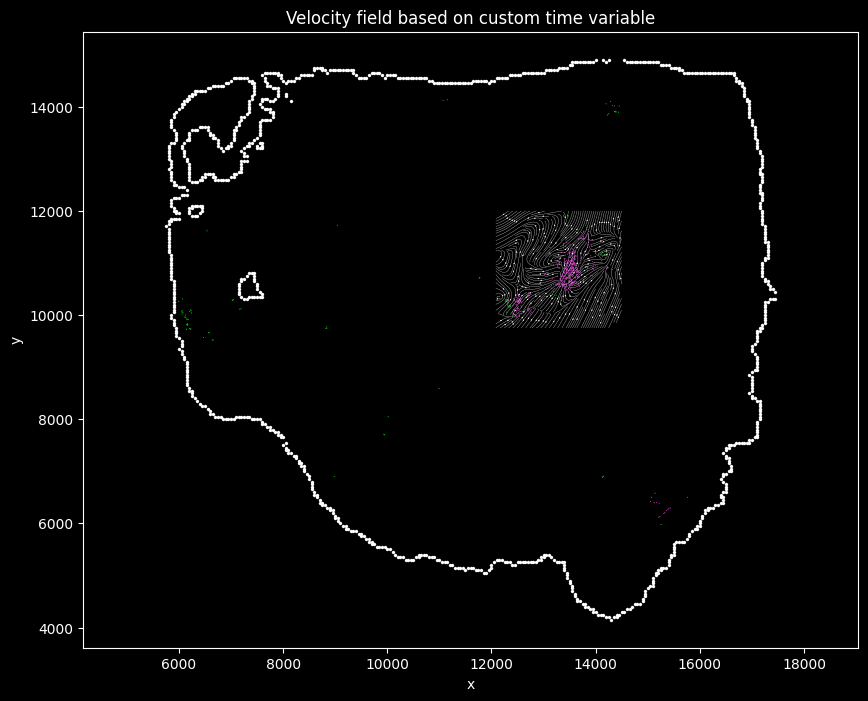

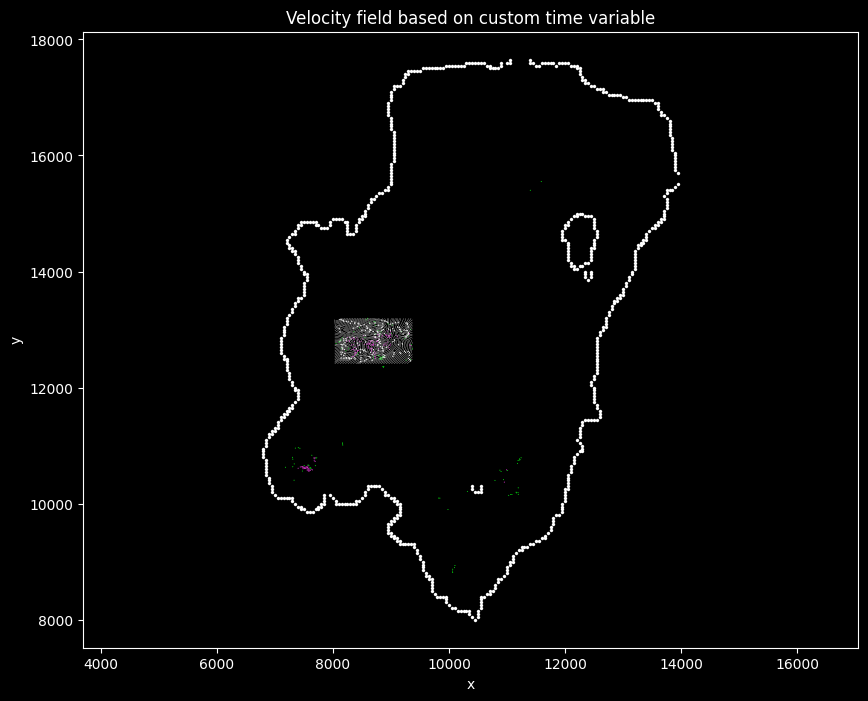

In [12]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import omicverse as ov  # Only needed if you use other ov features
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.interpolate import griddata
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage import gaussian_filter

plt.style.use('dark_background')

# Helper function for spatial velocity field plotting
def plot_stream_field(
    adata_section_path,
    section_prefix,
    LA_bin50,
    LA_cells,
    tissue_outline_color='white',
    box=None,  # box=(x_min, x_max, y_min, y_max)
    grid_num=25,
    smooth=1.1,
    density=1.0,
    outfig='fig4i_streamplot.png',
    pseudotime_col='slingshot_pseudotime'
):
    """
    Plot a streamplot of velocity fields based on spatial pseudotime gradients for B/Plasma cells in a tissue section.

    Args:
        adata_section_path (str): Path to section AnnData .h5ad file.
        section_prefix (str): Prefix for 'loc' ID for this section (should match batch/sample).
        LA_bin50 (AnnData): AnnData with bin50 annotation and LA_anno.
        LA_cells (AnnData): AnnData with all LA_cells, including pseudotime.
        tissue_outline_color (str): Color for tissue boundary.
        box (tuple): Optional. (x_min, x_max, y_min, y_max) restrict region for vector field.
        grid_num (int): Grid size for vector field interpolation.
        smooth (float): Smoothing sigma for velocity vectors.
        density (float): Scale/normalize arrows for visual clarity.
        outfig (str): Save figure path.
        pseudotime_col (str): Column in .obs giving pseudotime.
    """
    
    # Load spatial data for the section
    adata_sec = sc.read_h5ad(adata_section_path)
    adata_sec.obsm['X_umap'] = adata_sec.obsm['spatial']
    adata_sec.obs['loc'] = (
        section_prefix + '_' 
        + adata_sec.obs['bin50_x'].astype(str) 
        + '_' 
        + adata_sec.obs['bin50_y'].astype(str)
    )

    # Subselect for cells in LA_bin50 locations
    tmp = adata_sec[adata_sec.obs['loc'].isin(LA_bin50.obs['loc'])]
    # Merge TLS annotation
    tmp.obs = tmp.obs.merge(
        LA_bin50.obs[['loc', 'LA_anno']], on='loc'
    )
    # Filter to B/Plasma (with IGH or IGK/L chain sequence)
    tmp = tmp[
        (tmp.obs['IGHcdr3aa'].notna()) | 
        (tmp.obs['IGK/Lcdr3aa'].notna())
    ]
    # Tissue outline
    tissue_outline = pd.DataFrame(
        adata_sec.uns['tissue_outline'], columns=['x', 'y']
    )
    # TLS cells only for the color pointplot
    df1 = tmp.obs[tmp.obs['LA_anno'].isin(['TLS_inner', 'TLS_outer'])]

    tmp.obs.index = tmp.obs.index.astype(str)
    # Optionally restrict viewing window
    if box is not None:
        x_min, x_max, y_min, y_max = box
        tmp = tmp[
            (tmp.obs['x'] > x_min) & (tmp.obs['x'] < x_max) &
            (tmp.obs['y'] > y_min) & (tmp.obs['y'] < y_max)
        ]
    # Build LA_cells mapping for pseudotime
    LA_cells.obs['loc'] = (
        LA_cells.obs['batch'].astype(str)
        + '_' + LA_cells.obs['x'].astype(str) 
        + '_' + LA_cells.obs['y'].astype(str)
    )
    tmp.obs['loc'] = (
        section_prefix 
        + '_' + tmp.obs['x'].astype(str)
        + '_' + tmp.obs['y'].astype(str)
    )
    # Attach pseudotime
    extra = LA_cells.obs[['loc', pseudotime_col]].drop_duplicates('loc')
    tmp.obs = tmp.obs.merge(extra, on='loc', how='left')
    tmp.obs.drop(columns=['loc'], inplace=True)
    
    # Plot colored spatial annotation
    sc.pl.spatial(tmp, color=['LA_anno'], spot_size=50, show=False)
    plt.close()  # Avoid duplicate plot in script mode

    # Collect spatial positions and pseudotime
    position = tmp.obsm['spatial']
    # Safety: make sure pseudotime is float and in right order
    LA = tmp.obs
    time_values = LA[pseudotime_col].astype(float).values

    # Vector field calculation as described
    n_neigh = 50 if grid_num > 10 else 25
    nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(position)
    distances, indices = nbrs.kneighbors(position)
    # Transition matrix as weighted neighbor links
    indptr = [0]
    idx_list = []
    data_list = []
    for i in range(tmp.shape[0]):
        neighbors = indices[i]
        weights = 1.0 / (distances[i] + 1e-6)
        weights = weights / np.sum(weights)
        idx_list.extend(neighbors)
        data_list.extend(weights)
        indptr.append(indptr[-1] + len(neighbors))
    trans_neigh_csr = csr_matrix(
        (data_list, idx_list, indptr), shape=(position.shape[0], position.shape[0])
    )
    # Vector direction
    V = np.zeros(position.shape)
    for cell in range(position.shape[0]):
        cell_u, cell_v = 0.0, 0.0
        x1, y1 = position[cell][0], position[cell][1]
        for i, neigh in enumerate(indices[cell]):
            p = trans_neigh_csr[cell, neigh]
            if time_values[neigh] < time_values[cell]:
                p = -p
            x2, y2 = position[neigh][0], position[neigh][1]
            dist = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            if dist > 1e-6:
                sub_u = p * (x2 - x1) / dist
                sub_v = p * (y2 - y1) / dist
                cell_u += sub_u
                cell_v += sub_v
        V[cell][0] = cell_u / n_neigh if n_neigh > 0 else 0
        V[cell][1] = cell_v / n_neigh if n_neigh > 0 else 0
    # Define interpolation grid
    x = position[:, 0]
    y = position[:, 1]
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    xi = np.linspace(x_min, x_max, grid_num)
    yi = np.linspace(y_min, y_max, grid_num)
    Xi, Yi = np.meshgrid(xi, yi)
    # Interpolate components
    Ui = griddata((x, y), V[:, 0], (Xi, Yi), method='cubic', fill_value=0)
    Vi = griddata((x, y), V[:, 1], (Xi, Yi), method='cubic', fill_value=0)
    if smooth > 0:
        Ui = gaussian_filter(Ui, sigma=smooth)
        Vi = gaussian_filter(Vi, sigma=smooth)
    if density != 1.0:
        Ui = Ui * density
        Vi = Vi * density
    # Visualization
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=tissue_outline, x='x', y='y', color=tissue_outline_color, s=5)
    sns.scatterplot(data=df1, x='x', y='y', hue='LA_anno', palette=['#FF42F0', '#05FF11'], s=0.4, edgecolor=None, legend=False)
    plt.streamplot(Xi, Yi, Ui, Vi, density=2, color='white', linewidth=0.2, arrowsize=0.2)
    plt.axis('equal')
    plt.title('Velocity field based on custom time variable')
    plt.grid(False)
    plt.savefig(outfig, dpi=600, bbox_inches='tight')
    plt.show()

#### Example Usage ####

# Load common reference .h5ad files only once
LA_bin50 = sc.read_h5ad('/data1/fengyu/methods/zy/Review/for_github/fig4--ok/LA_bin50.h5ad')
LA_cells = sc.read_h5ad('/data1/fengyu/methods/zy/Review/for_github/fig4--ok/LA_cells.h5ad')

# Section 1 (e.g., D06047A2)
plot_stream_field(
    adata_section_path='/data3/zhangyang/Method_Final_analysis/D06047A2/test_analysis_celltype/D06047A2.h5ad',
    section_prefix='D06047A2',
    LA_bin50=LA_bin50,
    LA_cells=LA_cells,
    box=(12000, 14500, 9700, 12000),
    grid_num=25,
    smooth=1.1,
    density=10,
    outfig='fig4I1.png'
)

# Section 2 (e.g., D06047E1)
plot_stream_field(
    adata_section_path='/data3/zhangyang/Method_Final_analysis/D06047E1/test_analysis_celltype/D06047E1.h5ad',
    section_prefix='D06047E1',
    LA_bin50=LA_bin50,
    LA_cells=LA_cells,
    box=(8000, 9400, 12400, 13250),
    grid_num=8,
    smooth=0.8,
    density=0.5,
    outfig='fig4I2.png'
)

# 4M

Processing clone_family_id: 101.0


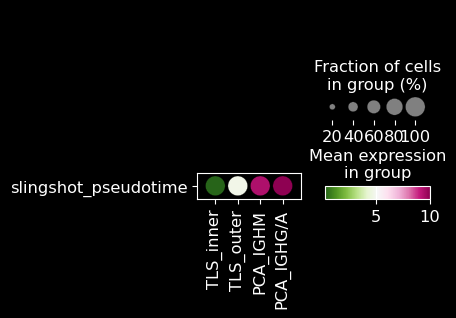

Processing clone_family_id: 491.0


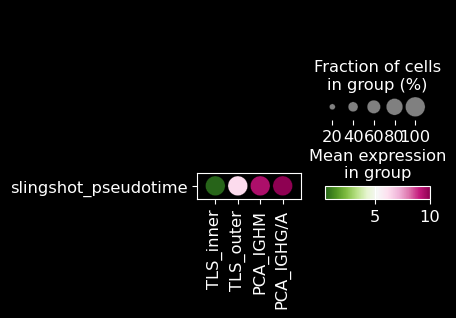

Processing clone_family_id: 840.0


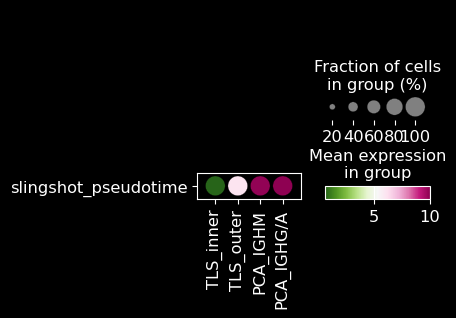

Processing clone_family_id: 685.0


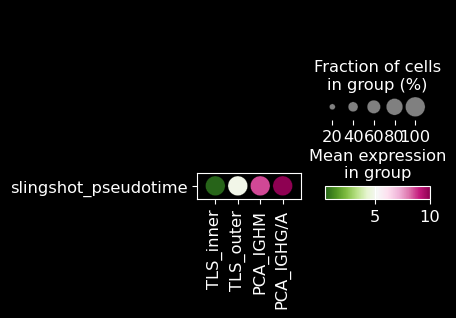

Processing clone_family_id: 657.0


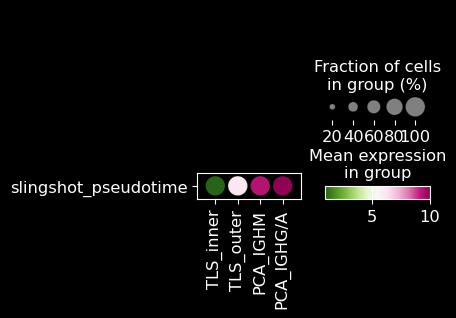

Processing clone_family_id: 637.0


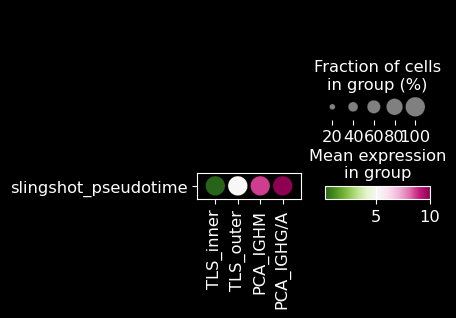

Processing clone_family_id: 198.0


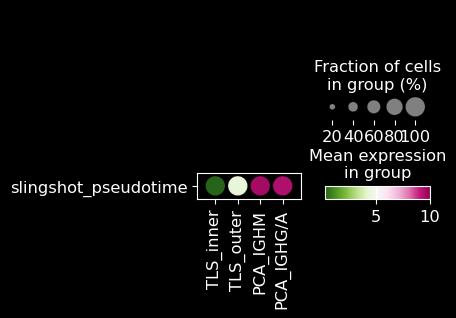

Processing clone_family_id: 310.0


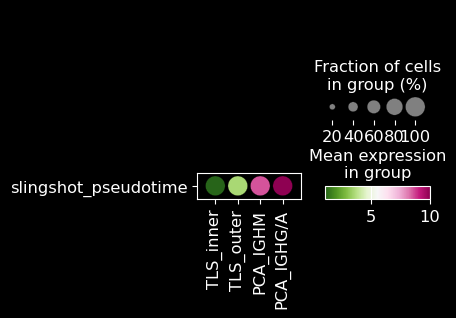

Processing clone_family_id: 457.0


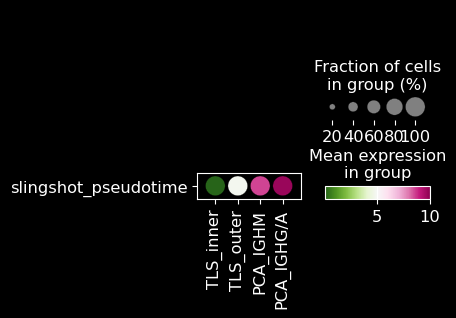

Processing clone_family_id: 478.0


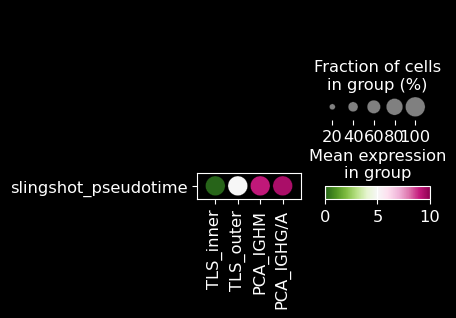

In [61]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from scipy.interpolate import splprep, splev
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# ---------- 数据读取 ----------

# 主数据
adata = sc.read_h5ad('/data1/fengyu/methods/zy/Review/for_github/fig4/LA_cells.h5ad')
# 克隆家族的注释数据
adata1 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047A2/test_analysis_celltype/D06047A2_with_family.h5ad')

# ---------- 数据预处理 ----------

# 只选当前批次的数据
tmp = adata[adata.obs['batch']=='D06047A2'].copy()
tmp.obs = tmp.obs.reset_index()     # 保证cellID列存在
tmp.obs = tmp.obs[tmp.obs['LA_anno'].notna()]  # 去除LA_anno缺失的行

# 合并clone_family_id信息（以cellID为索引）
tmp.obs = tmp.obs.merge(
    adata1.obs[['clone_family_id']],
    left_on='cellID', right_index=True, how='left'
)

# ---------- 克隆家族统计与筛选 ----------

# 只��析4个区域的细胞
region_list = ['PCA_IGHG/A', 'PCA_IGHM', 'TLS_outer', 'TLS_inner']
mask = tmp.obs['LA_anno'].isin(region_list)
sub = tmp.obs.loc[mask]

# 统计哪些clone_family_id恰好分布于4个区域
clones_in_all = (
    sub.groupby('clone_family_id')['LA_anno']
       .nunique()
       .eq(4)
       .pipe(lambda s: s[s].index)
)
clones = clones_in_all.tolist()

# 统计这些克隆在所有细胞中的数量，并排序
count_series = (
    tmp.obs['clone_family_id']
        .value_counts()
        .reindex(clones, fill_value=0)
        .astype(int)
)
count_series_sorted = count_series.sort_values(ascending=False)

# 选取细胞数最多的前10个克隆家族id
top10_clones = count_series_sorted.head(10).index.tolist()

# ---------- 组织/空间可视化准备 ----------

# 加载组织边界信息
tissue_outline = pd.DataFrame(adata1.uns['tissue_outline'], columns=['x','y'])

# 准备细胞空间边界
array_2d = adata1.obsm['cell_border'].reshape(-1, adata1.obsm['cell_border'].shape[-1])
df_cellborder = pd.DataFrame(array_2d)
df_cellborder['cellID'] = df_cellborder.index // 32
df_cellborder['cellID'] = df_cellborder['cellID'].astype(str)
df_cellborder.rename(columns={0:'x', 1:'y'}, inplace=True)
df_cellborder = df_cellborder[(df_cellborder['x'] != 32767) & (df_cellborder['y'] != 32767)]

# 合并坐标，转int
adata1.obs['cellID'] = adata1.obs['cellID'].astype(str)
df_cellborder = pd.merge(df_cellborder, adata1.obs[['x', 'y', 'cellID']], on='cellID', how='left')
df_cellborder['x'] = df_cellborder['x_x'] + df_cellborder['x_y']
df_cellborder['y'] = df_cellborder['y_x'] + df_cellborder['y_y']
df_cellborder = df_cellborder[['cellID', 'x', 'y']]

# ---------- 空间可视化示例（以clone_id为101.0为例，可用top10循环） ----------

def plot_spatial_overview(clone_id, tmp, df_cellborder, tissue_outline, out_path='overview.pdf'):
    """
    空间分布图，细胞边界颜色按pseudotime映射
    """
    tmp1 = tmp.obs[tmp.obs['clone_family_id'] == clone_id]
    data_GA = tmp1.copy()
    data_GA['cellID'] = data_GA['cellID'].astype(int)
    cell_list1 = data_GA['cellID'].tolist()

    df_cellborder['cellID'] = df_cellborder['cellID'].astype(int)
    cell_border1 = df_cellborder[df_cellborder['cellID'].isin(cell_list1)]
    cell_border_list1 = cell_border1.groupby('cellID').apply(
        lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]).tolist()
    filtered_cell_borders_list1 = [np.array(cell) for cell in cell_border_list1]

    time_list = tmp1['slingshot_pseudotime'].tolist()

    # 绘图
    fig, ax = plt.subplots(figsize=(5, 4))
    BG_COLOR = 'black'
    TXT_COLOR = 'white'
    fig.patch.set_facecolor(BG_COLOR)
    ax.set_facecolor(BG_COLOR)
    ax.tick_params(colors=TXT_COLOR, labelsize=8)
    for spine in ax.spines.values():
        spine.set_color(TXT_COLOR)

    def smooth_boundary(boundary, smoothness=0.5):
        x, y = boundary[:, 0], boundary[:, 1]
        x = np.append(x, x[0]); y = np.append(y, y[0])
        tck, u = splprep([x, y], s=smoothness*len(x), per=True)
        u_new = np.linspace(u.min(), u.max(), 100)
        x_new, y_new = splev(u_new, tck, der=0)
        return np.column_stack((x_new, y_new))

    # 按pseudotime着色
    cmap = cm.get_cmap('PiYG_r')
    norm = Normalize(vmin=1, vmax=12)

    patches = []
    for i, cell_boundary in enumerate(filtered_cell_borders_list1):
        smooth = smooth_boundary(cell_boundary, 0.8)
        codes = [Path.LINETO] * len(smooth)
        codes[0] = Path.MOVETO
        codes[-1] = Path.CLOSEPOLY
        color = cmap(norm(time_list[i]))
        patches.append(PathPatch(Path(smooth, codes),
                                edgecolor=TXT_COLOR,
                                facecolor=color,
                                lw=0.05, antialiased=True))
    ax.add_collection(PatchCollection(patches, match_original=True))

    # 组织边界和细胞散点
    sns.scatterplot(data=tissue_outline, x='x', y='y',
                    color=TXT_COLOR, s=1, edgecolor=None)

    plt.grid(False)
    plt.axis('equal')
    plt.savefig(out_path, dpi=600, bbox_inches='tight', facecolor=BG_COLOR, edgecolor='none')
    plt.close()

# 示例：绘制clone_id等于101.0的空间分布
plot_spatial_overview(clone_id=101.0, tmp=tmp, df_cellborder=df_cellborder, tissue_outline=tissue_outline,
                      out_path='Figure4M_overview.pdf')

# ---------- Dotplot可视化：按前10个克隆家族循环绘图 ----------

dotplot_order = ['TLS_inner','TLS_outer','PCA_IGHM','PCA_IGHG/A']   # 分组顺序

for clone_id in top10_clones:
    print(f"Processing clone_family_id: {clone_id}")
    df = tmp[tmp.obs['clone_family_id'] == clone_id].copy()
    df.obs = df.obs[df.obs['LA_anno'].notna()]
    df.obs['LA_anno'] = df.obs['LA_anno'].astype('category').cat.set_categories(dotplot_order)
    # 画Dotplot
    sc.pl.dotplot(
        df,
        var_names='slingshot_pseudotime',
        groupby='LA_anno',
        swap_axes=True,
        vmax=10,
        cmap='PiYG_r',
        save=f'family_{clone_id}.pdf'
    )

# ---------- END ----------

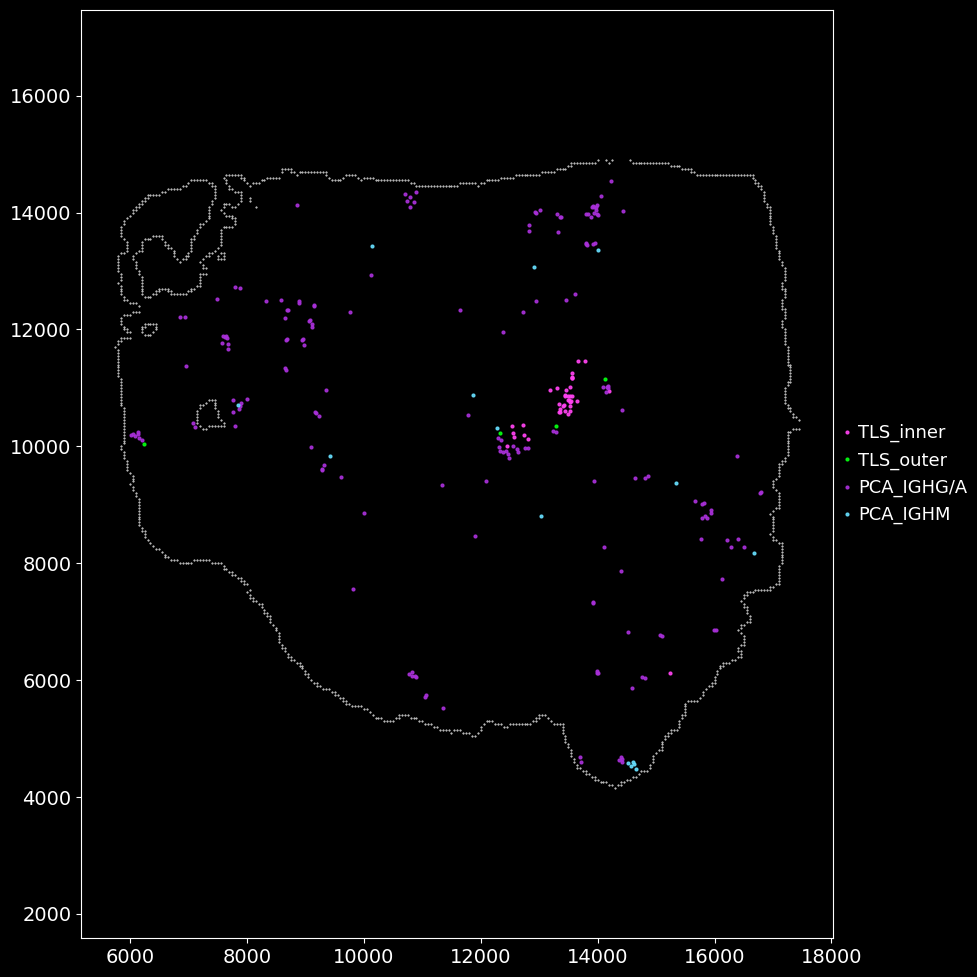

完成！clone_family_id==101.0 空间分布图已保存为 Figure4M_clone101_overview.png


In [67]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# ----------- 1. 读取数据 -----------

# 读取主数据和clone信息（请用你的实际路径）
adata = sc.read_h5ad('/data1/fengyu/methods/zy/Review/for_github/fig4/LA_cells.h5ad')
adata1 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047A2/test_analysis_celltype/D06047A2_with_family.h5ad')

# ----------- 2. 选取符合条件的细胞，并合并克隆家族信息 -----------

# 只选batch为D06047A2
tmp = adata[adata.obs['batch']=='D06047A2'].copy()
tmp.obs = tmp.obs.reset_index()                       # 确保 cellID 有一列
tmp.obs = tmp.obs[tmp.obs['LA_anno'].notna()]         # 去除LA_anno缺失

# 合并clone_family_id信息（按cellID关联）
tmp.obs = tmp.obs.merge(
    adata1.obs[['clone_family_id']],
    left_on='cellID', right_index=True, how='left'
)

# ----------- 3. 提取clone_family_id为101.0的细胞 -----------

clone_id = 101.0
tmp1 = tmp.obs[tmp.obs['clone_family_id'] == clone_id].copy()
tmp1 = tmp1.reset_index(drop=True)

# ----------- 4. 组织外形坐标 -----------

tissue_outline = pd.DataFrame(adata1.uns['tissue_outline'], columns=['x', 'y'])

# ----------- 5. 为LA_anno上色 -----------

anno_color = {
    'TLS_inner':  '#FF42F0',
    'TLS_outer':  '#05FF11',
    'PCA_IGHG/A': '#A830D8',
    'PCA_IGHM':   '#66DDFC'
}

# ----------- 6. 空间散点图绘制 -----------

fig, ax = plt.subplots(figsize=(10, 10))
BG_COLOR = 'black'
TXT_COLOR = 'white'

fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)
ax.tick_params(colors=TXT_COLOR)

for spine in ax.spines.values():
    spine.set_color(TXT_COLOR)

# 组织外形（灰白色）
plt.scatter(tissue_outline['x'], tissue_outline['y'], color=TXT_COLOR, s=0.2, label=None)

# 画四种LA_anno分区的散点
for label, color in anno_color.items():
    idx = tmp1['LA_anno'] == label
    plt.scatter(tmp1.loc[idx, 'x'], tmp1.loc[idx, 'y'],
                s=4, color=color, label=label, alpha=0.9)

# 图例
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
for text in legend.get_texts():
    text.set_color(TXT_COLOR)

plt.grid(False)
plt.axis('equal')
plt.tight_layout()

# ----------- 7. 保存高分辨图片 -----------

plt.savefig('Figure4M_clone101_overview.png', dpi=600, bbox_inches='tight', facecolor=BG_COLOR)
plt.show()

print("完成！clone_family_id==101.0 空间分布图已保存为 Figure4M_clone101_overview.png")